In [3]:
import torch ## main pytorch library, gives access to tensors, random generators, utils like data loaders, etc.
import torch.nn as nn ## neural network stuff like layers
import torch.nn.functional as F ## functions used in nn like activation functions, loss functions, drop functions, etc.
import torch.optim as optim ## optimizers

import torchvision ## library related to image analysis including ready datasets and trained models
import torchvision.transforms as transforms ## modules help with image data preprocessing such as transfromations

import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
sns.set()

import numpy as np

torch.manual_seed(42)

### Load Dataset
* Remember, despite providing the transforms as a parameter when preparing the dataset, it won't apply the transforms functions until you use dataloader to load the data.
    * here a data pipeline is created through which the data will flow and multiple transforms will be applied.
However, until torch.utils.data.DataLoader is called, transformations on the data won't be applied

In [4]:
train_batch_size = 240
test_batch_size = 1000
# specify the transforms
train_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(0.13, 0.31)
                                    ])

# prepare the dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)

validation_samples_n = int(0.1*len(mnist_dataset))
from torch.utils.data import random_split
# Divide the dataset into train and validation sets
trainset, validationset = random_split(mnist_dataset, [len(mnist_dataset) - validation_samples_n, validation_samples_n])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=len(validationset), shuffle=True, num_workers=4)

# explore the loaded dataset
images, labels = next(iter(trainloader))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(images.min(), images.max()))
print('Mean Pixel Value: {} \nPixel Values Std: {}'.format(images.float().mean(), images.float().std()))

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=train_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True, num_workers=4)


Min Pixel Value: -0.4193548262119293 
Max Pixel Value: 2.8064515590667725
Mean Pixel Value: -0.005795554257929325 
Pixel Values Std: 0.9836686849594116


In [5]:
images[0].shape

torch.Size([1, 28, 28])

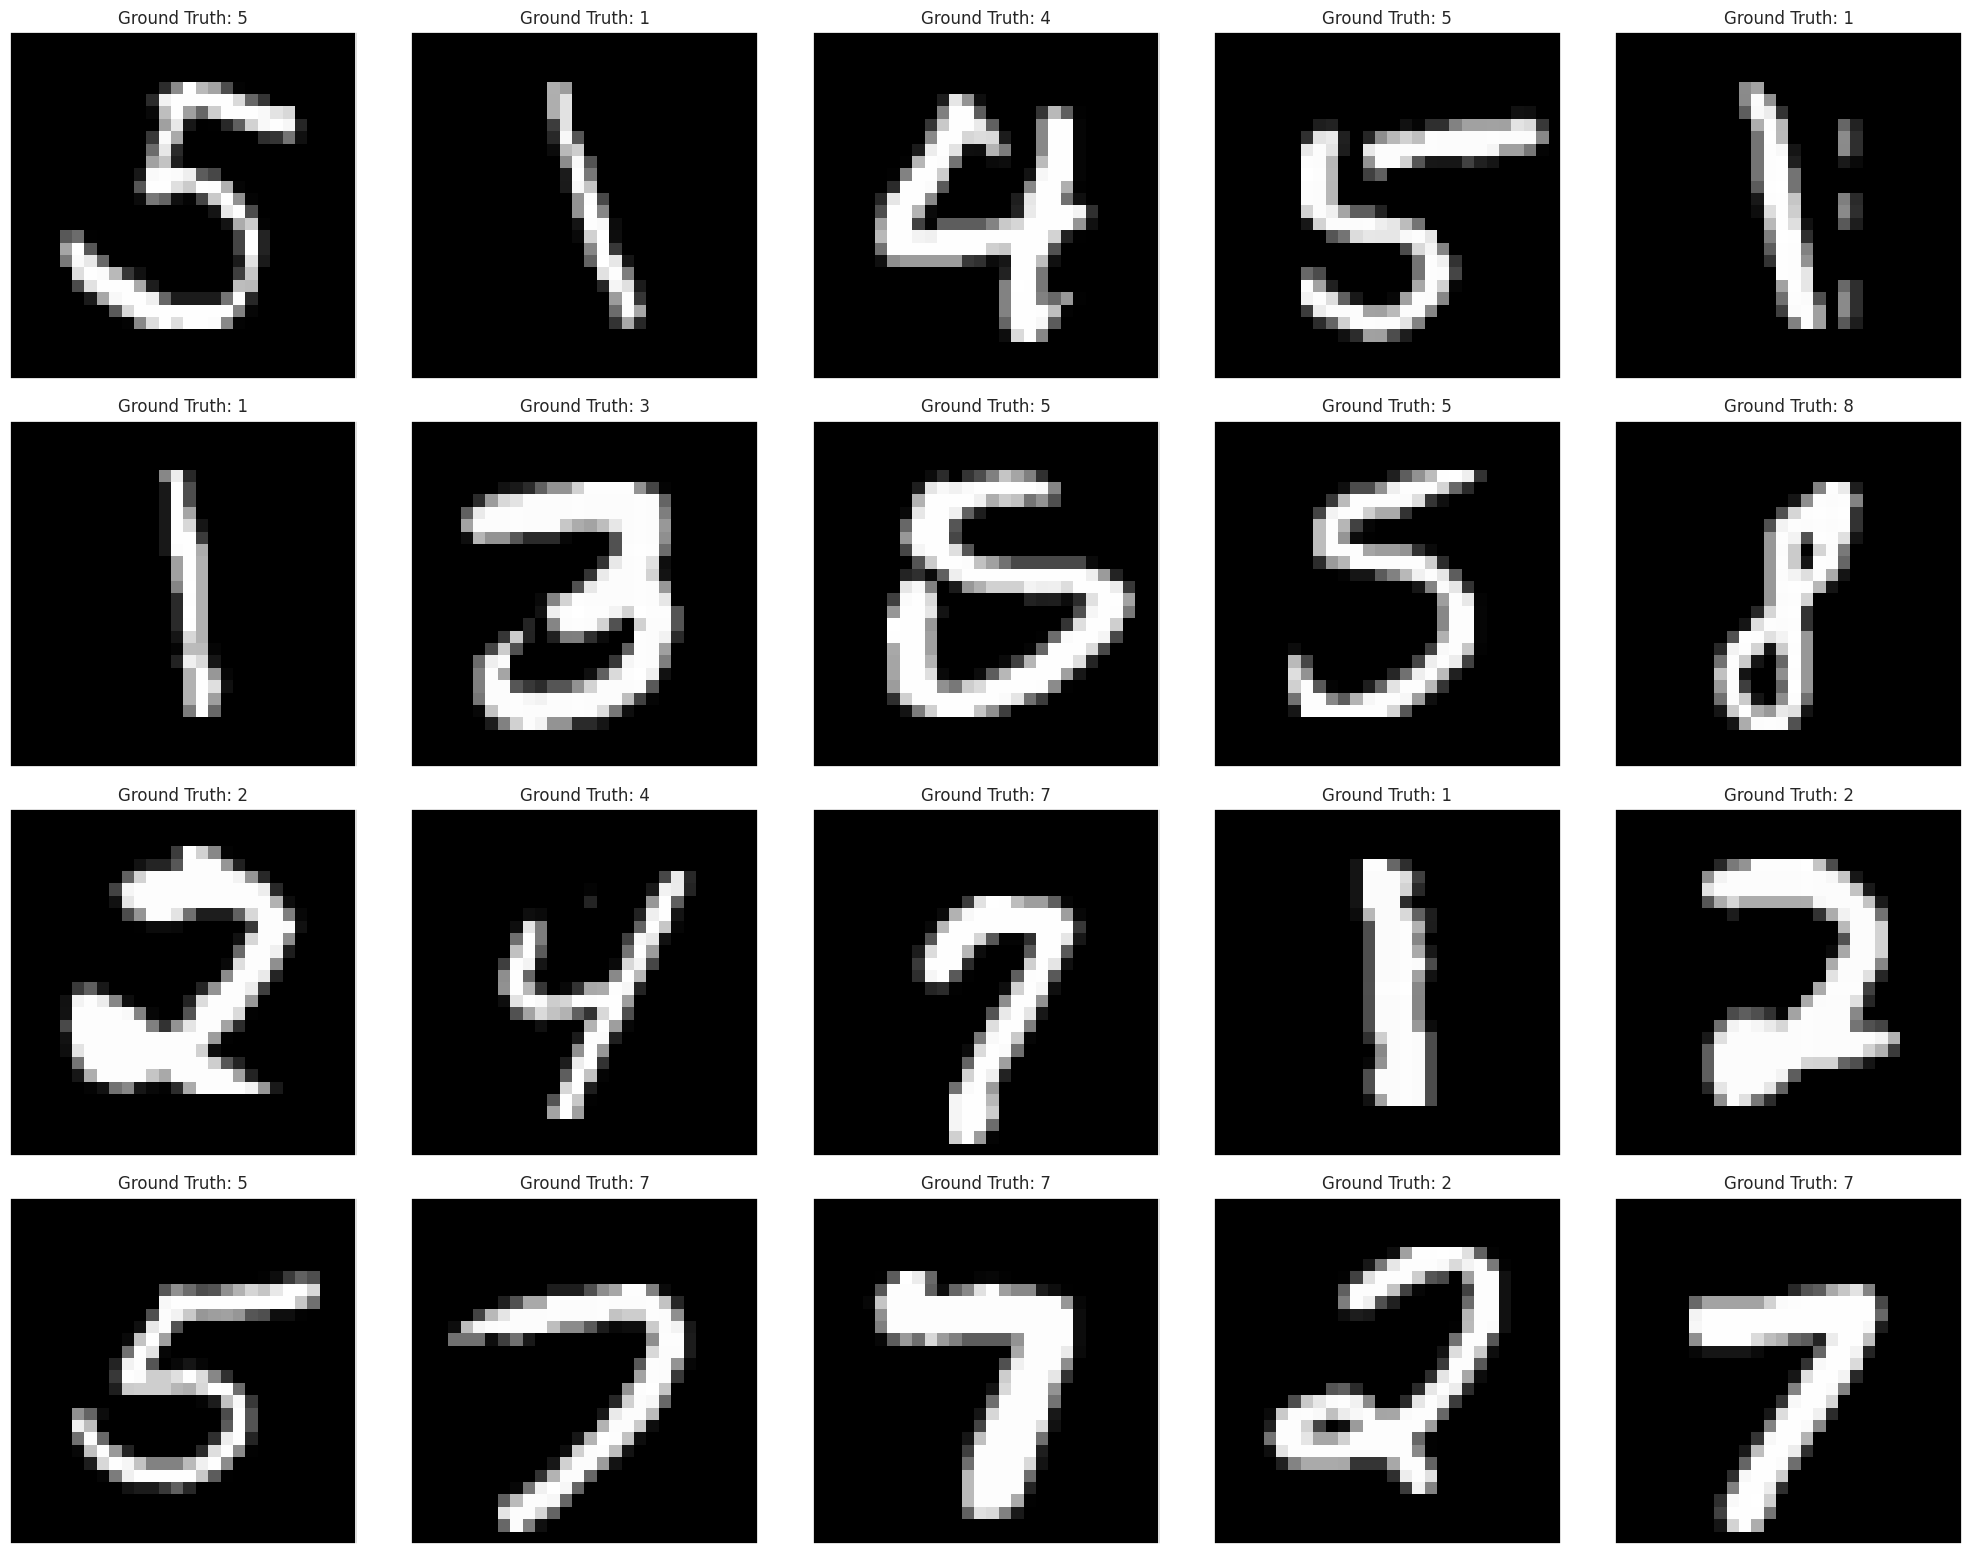

In [6]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])
fig;

### Build the Neural Network Model
* nn.Module or nn.Sequential can be used similarly
    * as explained [here](https://discuss.pytorch.org/t/differences-between-writing-models-with-nn-sequential-vs-creating-a-class/17470):
        * You can use whatever fits your use case.
        * While some people like to use the nn.Sequential approach a lot, I usually just use it for small sub-modules and like to define my model in a functional way, i.e. derive from nn.Module and write the forward method myself.
        * This approach gives you more flexibility in my opinion, since you are able to easily create skip connections etc.
        * On the other hand if you just want to stack layers together, nn.Sequential is totally fine.
    * example of nn.Sequential
        * `net = nn.Sequential(
      nn.Linear(3, 4),
      nn.Sigmoid(),
      nn.Linear(4, 1),
      nn.Sigmoid()
      ).to(device)`
___
* The nn.Module is a base class for all neural network modules in PyTorch.
* when calling init of super, in previous versions of python, one had to specify two arguments subclass name and self
    * `super(SubclassName, self).__init__()`

In [7]:
def set_device():
    device = torch.device('cpu')
    if torch.cuda.is_available():
        device = torch.device('cuda')
    return device

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.activation = F.relu
        self.out_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.to(device=set_device())
        self.layer1 = nn.Linear(28 * 28 * 1, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer2(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer3(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer4(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer5(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer6(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.out_activation(self.output(x))
        # x = self.output2(x)
        return x

# Instantiate the model
# model = Net()
# print(model)
# model.to(device=set_device())

# torch.Size([250, 512])
# torch.Size([250, 256])
# torch.Size([250, 128])
# torch.Size([250, 64])
# torch.Size([250, 32])
# torch.Size([250, 16])

#### Model 2

In [8]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.activation = F.relu
        self.out_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.to(device=set_device())
        self.layer1 = nn.Linear(28 * 28 * 1, 128)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        # print(x.shape)
        # x = self.activation(self.layer2(x))
        # x = self.dropout(x)
        # # print(x.shape)
        # x = self.activation(self.layer3(x))
        # x = self.dropout(x)
        # # print(x.shape)
        x = self.activation(self.layer4(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer5(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer6(x))
        x = self.dropout(x)
        # print(x.shape)
        x = self.out_activation(self.output(x))
        # x = self.output2(x)
        return x


### Model 3

In [9]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.activation_relu = F.relu
        self.activation_tanh = F.tanh
        self.out_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.to(device=set_device())
        self.layer1 = nn.Linear(28 * 28 * 1, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 50)
        self.layer4 = nn.Linear(50, 25)
        self.layer5 = nn.Linear(25, 13)
        self.output = nn.Linear(13, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation_tanh(self.layer1(x))
        x = self.activation_relu(self.layer2(x))
        x = self.activation_relu(self.layer3(x))
        x = self.activation_relu(self.layer4(x))
        x = self.activation_relu(self.layer5(x))
        x = self.dropout(x)
        
        x = self.out_activation(self.output(x))
        return x

#### Initialize Model

In [35]:
model = Net2()

### define the optimizers and loss function

In [36]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

#### Early Stopping class

In [37]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum tolerance to be counted as improved/worsened
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf

    # return True when encountering _patience_ times decrease in validation loss 
    def early_stop_check(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation decreased
        elif validation_loss > (self.min_validation_loss+self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    # class EarlyStopper:
    #     def __init__(self, patience=1, min_delta=0):
    #         self.patience = patience
    #         self.min_delta = min_delta
    #         self.counter = 0
    #         self.min_validation_loss = np.inf
    # def early_stop(self, validation_loss):
    #     if validation_loss < self.min_validation_loss:
    #         self.min_validation_loss = validation_loss
    #         self.counter = 0
    #     elif validation_loss > (self.min_validation_loss + self.min_delta):
    #         self.counter += 1
    #         if self.counter >= self.patience:
    #             return True
    #     return False

### Train the Model

In [45]:
model.train()

early_stopper = ValidationLossEarlyStopping(patience=3, min_delta=10)
n_epochs = 100
train_batch_losses = []
train_epoch_losses = []
train_epoch_accuracy = []

validation_epoch_losses = []
validation_epoch_accuracy = []
for epoch_i in range(n_epochs):
    train_batch_loss_sum = 0
    validation_loss_sum = 0
    correct_count_t = 0
    correct_count_v = 0
    total_t = 0
    total_v = 0
    for batch_i, (input, target) in enumerate(trainloader):
        # making a pridiction in forward pass
        y_hat = model(input)
        # calculating the loss between original and predicted data points
        loss = criterion(y_hat, target)
        # sum the losses
        current_batch_loss= loss.item()
        train_batch_loss_sum += current_batch_loss
        # store loss into list
        train_batch_losses.append(current_batch_loss)
        # calculate the train accuracy
        # torch.max returns value and index of largest number
        # since softmax produces probability for 0 classes,
        # the index will exactly match the corresponding number
        _, predicted = torch.max(y_hat.data, 1)
        total_t += target.size(0)
        correct_count_t += (predicted == target).sum().item()  

        # zeroing gradients after each iteration
        optimizer.zero_grad()
        # backward pass for computing the gradients of the loss w.r.t to learnable parameters
        loss.backward()
        # updateing the parameters after each iteration
        optimizer.step()

    train_epoch_losses.append(round(train_batch_loss_sum/len(trainloader), 4))
    train_epoch_accuracy.append(round((correct_count_t/total_t)*100,2))
    
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch_i, (input, target) in enumerate(validationloader):
            y_hat = model(input)
            loss = criterion(y_hat, target)
            current_validation_loss = loss.item()
            validation_loss_sum += current_validation_loss
            
            # calculate validation accuracy
            _, predicted = torch.max(y_hat.data, 1)
            total_v += target.size(0)
            correct_count_v += (predicted == target).sum().item()
    
    validation_epoch_losses.append(round(validation_loss_sum / len(validationloader), 4))
    validation_epoch_accuracy.append(round((correct_count_v / total_v) * 100, 2))
    
    print(f'Epoch: {epoch_i+1}, Train Loss: {train_epoch_losses[-1]}, Train Accuracy: {train_epoch_accuracy[-1]}%, Validation Loss: {validation_epoch_losses[-1]}, Validation Accuracy: {validation_epoch_accuracy[-1]}%')
    if(early_stopper.early_stop_check(validation_epoch_losses[-1])):
        print(f"Early Stopping at Epoch:{epoch_i+1}")
        n_epochs = epoch_i+1  # update the total epochs to make the plots stable which depend on this number
        break
    model.train()
        # self.layer1 = nn.Linear(780, 512)
        # self.layer2 = nn.Linear(512, 256)
        # self.layer3 = nn.Linear(256, 128)
        # self.layer4 = nn.Linear(128, 64)
        # self.layer5 = nn.Linear(64, 32)
        # self.layer6 = nn.Linear(32, 16)
        
## Udacity notebook time:   
    # Epoch: 25, Train Loss: 1.4866, Train Accuracy: 0.43%, Validation Loss: 1.49, Validation Accuracy: 97.05%
    # 3min 40s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
## vscode
    # Epoch: 25, Train Loss: 1.5084, Train Accuracy: 95.35%, Validation Loss: 1.5013, Validation Accuracy: 95.97%
    # 28min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
    # Epoch: 100, Train Loss: 1.508, Train Accuracy: 95.31%, Validation Loss: 1.498, Validation Accuracy: 96.32%

Epoch: 1, Train Loss: 1.4908, Train Accuracy: 97.03%, Validation Loss: 1.5033, Validation Accuracy: 95.78%
Epoch: 2, Train Loss: 1.5089, Train Accuracy: 95.23%, Validation Loss: 1.4944, Validation Accuracy: 96.67%
Epoch: 3, Train Loss: 1.5071, Train Accuracy: 95.4%, Validation Loss: 1.5009, Validation Accuracy: 96.0%
Epoch: 4, Train Loss: 1.51, Train Accuracy: 95.12%, Validation Loss: 1.4991, Validation Accuracy: 96.22%
Epoch: 5, Train Loss: 1.5094, Train Accuracy: 95.18%, Validation Loss: 1.5034, Validation Accuracy: 95.78%
Epoch: 6, Train Loss: 1.5051, Train Accuracy: 95.6%, Validation Loss: 1.4959, Validation Accuracy: 96.53%
Epoch: 7, Train Loss: 1.5033, Train Accuracy: 95.8%, Validation Loss: 1.4979, Validation Accuracy: 96.32%
Epoch: 8, Train Loss: 1.5069, Train Accuracy: 95.42%, Validation Loss: 1.4974, Validation Accuracy: 96.37%
Epoch: 9, Train Loss: 1.5082, Train Accuracy: 95.29%, Validation Loss: 1.4977, Validation Accuracy: 96.33%
Epoch: 10, Train Loss: 1.5056, Train Accura

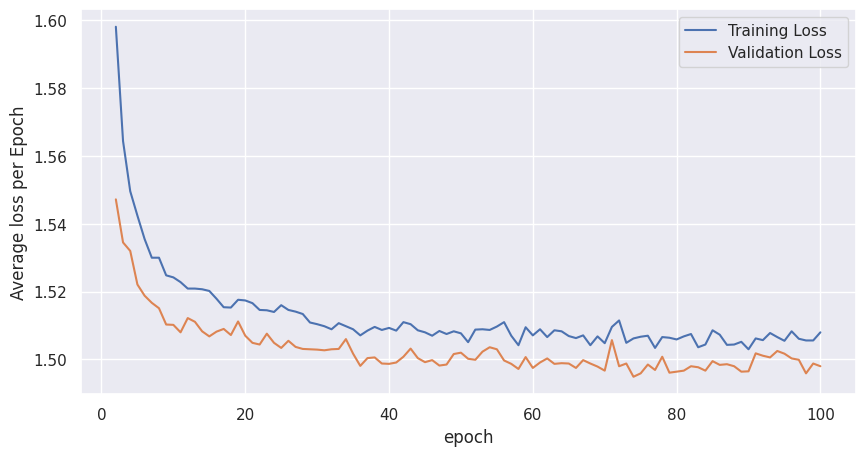

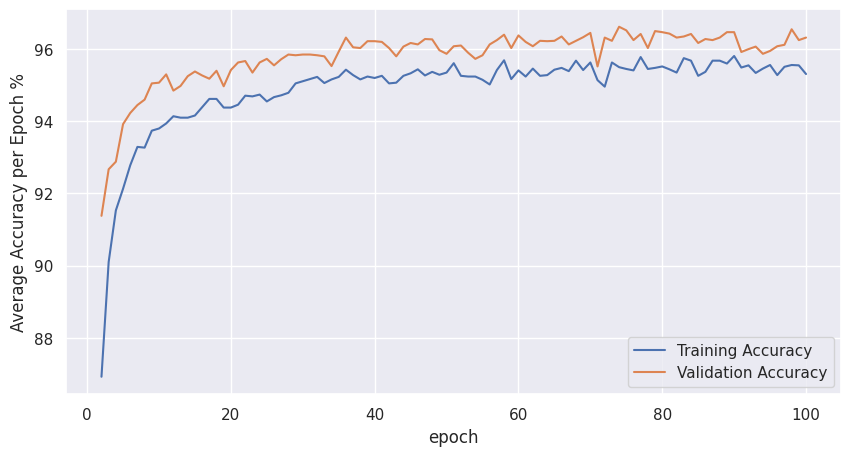

In [39]:
from matplotlib.pyplot import figure
# figure(figsize=(4, 6), dpi=200)
figure(figsize=(10, 5))

# plt.plot(train_batch_losses, label = "Adam Optimizer")
# plt.plot(train_epoch_losses2, marker="_", label = "Adam Optimizer")

# the difference in the first train loss and validation loss is very high, to understand the plot, it is better to exclude it
# plt.plot(range(1,n_epochs+1), train_epoch_losses, label = "Training Loss")
# plt.plot(range(1,n_epochs+1), validation_epoch_losses, label = "Validation Loss")
plt.plot(range(2,n_epochs+1), train_epoch_losses[1:], label = "Training Loss")
plt.plot(range(2,n_epochs+1), validation_epoch_losses[1:], label = "Validation Loss")

plt.xlabel('epoch')
plt.ylabel('Average loss per Epoch')
plt.legend()
plt.show()

### plot accuracy
figure(figsize=(10, 5))

# the difference in the first train accuracy and validation accuracy is very high, to understand the plot, it is better to exclude it
# plt.plot(range(1,n_epochs+1), train_epoch_accuracy, label = "Training Accuracy")
# plt.plot(range(1,n_epochs+1), validation_epoch_accuracy, label = "Validation Accuracy")
plt.plot(range(2,n_epochs+1), train_epoch_accuracy[1:], label = "Training Accuracy")
plt.plot(range(2,n_epochs+1), validation_epoch_accuracy[1:], label = "Validation Accuracy")


plt.xlabel('epoch')
plt.ylabel('Average Accuracy per Epoch %')
plt.legend()
plt.show()
# print(type(train_epoch_accuracy))

In [40]:
len(train_batch_losses)

54000

In [41]:
# sum=0
# for sample_i, (input, target) in enumerate(trainloader):
#     print(target)
#     # break


# it contains the result for the last batch (batch of 5 samples)
# the output of final layer was 16
print(y_hat.shape) 
print(target)
print((y_hat[0]))


torch.Size([6000, 10])
tensor([4, 6, 4,  ..., 7, 4, 8])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [42]:
# torch.max(y_hat.data, 1)
y_hat

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

### Test the model

In [43]:
model.eval()
test_batch_loss = []
test_batch_accuracy = []
test_correct_predictions = 0
total_samples_test = 0

with torch.no_grad():
    for batch_id, (input, target) in enumerate(testloader):
        # calculate the prediction
        y_hat = model(input)
        
        # calculate the loss
        loss = criterion(y_hat, target)
        current_test_loss = loss.item()
        test_batch_loss.append(current_test_loss)
        # test_loss_sum += current_test_loss
        
        # caclculate test accuracy
        _, predicted = torch.max(y_hat.data, 1)
        test_batch_samples_count = target.size(0)
        test_correct_pred_batch = (predicted == target).sum().item()
        test_batch_accuracy.append(round((test_correct_pred_batch / test_batch_samples_count) * 100, 2))

        print(f'Batch: {batch_id+1}, Test Loss: {test_batch_loss[-1]}, Test Accuracy: {test_batch_accuracy[-1]}%')
    test_avg_loss = round(sum(test_batch_loss) / len(test_batch_loss), 4)
    test_avg_accuracy = round(sum(test_batch_accuracy) / len(test_batch_accuracy), 4)
    print(f'Average Loss: {test_avg_loss}, Average Accuracy; {test_avg_accuracy}%')
    
    # Average Loss: 1.5002, Average Accuracy; 96.08%
    # after 100 epochs: Average Loss: 1.4938, Average Accuracy; 96.73%

Batch: 1, Test Loss: 1.493149757385254, Test Accuracy: 96.8%
Batch: 2, Test Loss: 1.4944452047348022, Test Accuracy: 96.7%
Batch: 3, Test Loss: 1.4984407424926758, Test Accuracy: 96.3%
Batch: 4, Test Loss: 1.4961514472961426, Test Accuracy: 96.5%
Batch: 5, Test Loss: 1.490734338760376, Test Accuracy: 97.0%
Batch: 6, Test Loss: 1.5037486553192139, Test Accuracy: 95.7%
Batch: 7, Test Loss: 1.4896254539489746, Test Accuracy: 97.2%
Batch: 8, Test Loss: 1.4959672689437866, Test Accuracy: 96.5%
Batch: 9, Test Loss: 1.484877109527588, Test Accuracy: 97.6%
Batch: 10, Test Loss: 1.4911471605300903, Test Accuracy: 97.0%
Average Loss: 1.4938, Average Accuracy; 96.73%


In [44]:
# torch.save(model, 'mnist_model_pytorch.pt')